### <div style="text-align: left; background-color:#CFD9F1 ; font-family: Trebuchet MS; color: #0A3399; padding: 15px; line-height:1;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px"> Xgboost Hyperparameter Tuning </div>

In [1]:
#1.0.0 Libraries for data frame
import pandas as pd
import numpy as np

#1.0.1 Calling libraries for train and test data split
from sklearn.model_selection import train_test_split

#1.0.2 calling libraries for performance matrix
from sklearn.metrics import mean_squared_error,f1_score, r2_score
from sklearn.metrics import explained_variance_score, mean_absolute_error
from sklearn.metrics import auc, roc_curve
#1.0.3 This library means for reduce the dimensions 
from sklearn.decomposition import PCA

#1.0.4 libraries for hyperparamenter optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold
#1.0.5 Calling plotting libraries for visualizing the data 
import seaborn as sn
import matplotlib.pyplot as plt

# 1.13 Used in Randomized parameter search
from skopt import BayesSearchCV
from skopt.space import Real,Integer,Categorical
from scipy.stats import uniform

#1.14 calling lightgbm
import lightgbm as lgb
from lightgbm import LGBMRegressor

<div style="font-family: Segoe UI; line-height: 2; color: #DE3163; text-align: justify;font-size: 25px">
    <b>Loading Dataset</b>



In [2]:
#Reading the data
xdata=pd.read_csv("../input/walmart-sales-dataset-of-45stores/walmart-sales-dataset-of-45stores.csv")

<div style="font-family: Segoe UI; line-height: 2; color: #DE3163; text-align: justify;font-size: 25px">
     <b>Pre-processing data</b>


In [3]:
#Chekcing the unique value counts
xdata.nunique().value_counts()

45      1
143     1
6435    1
2       1
3528    1
892     1
2145    1
349     1
dtype: int64

In [4]:
# Number of columns
xdata.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [5]:
#datatypes for each column
xdata.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

In [6]:
#selecting the features 
hdata=xdata.copy()
xdata.drop(['Date'],axis=1, inplace=True)
target='Weekly_Sales'
features=[fe for fe in xdata.columns if fe not in target]

In [7]:
#Features name
features

['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

<div style="font-family: Segoe UI; line-height: 2; color: #DE3163; text-align: justify;font-size: 25px">
     <b>Feature Engineering</b>


In [8]:
#Identifying the categorical and numerical feature
nu=xdata[features].nunique().sort_values(ascending=False)
cf=[]; nf=[]

for x in range(xdata[features].shape[1]):
    if nu.values[x]<=45:
        print("Categorical",x)
        cf.append(nu.index[x])
    else:
          print("Numerical",x)
          nf.append(nu.index[x])

Numerical 0
Numerical 1
Numerical 2
Numerical 3
Categorical 4
Categorical 5


In [9]:
#categorical features
cf

['Store', 'Holiday_Flag']

In [10]:
#Numerical features
nf

['Temperature', 'CPI', 'Fuel_Price', 'Unemployment']

<div style="font-family: Segoe UI; line-height: 2; color: #DE3163; text-align: justify;font-size: 25px">
    <b>Visualizing Numerical features:</b>


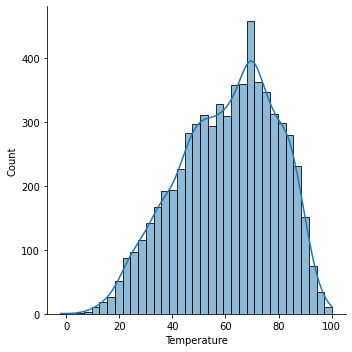

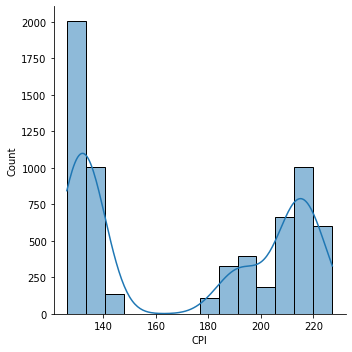

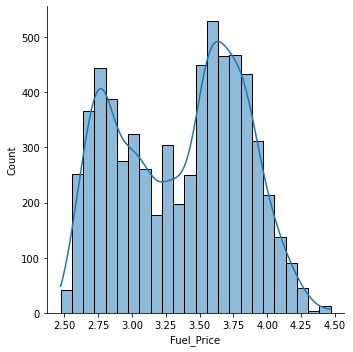

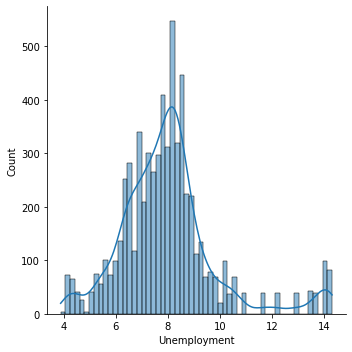

In [11]:
for i in range(len(nf)):
    sn.displot(xdata[nf[i]], kde=True)
    
plt.tight_layout()
plt.show()


<div style="font-family: Segoe UI; line-height: 2; color: #DE3163; text-align: justify;font-size: 25px">
    <b>Visualizing categorical features:</b>

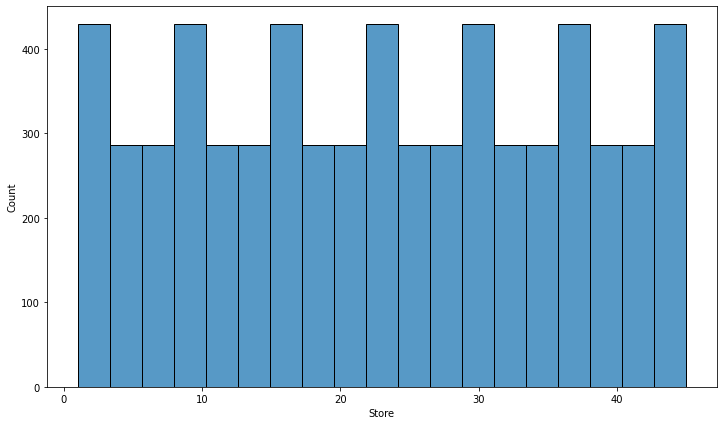

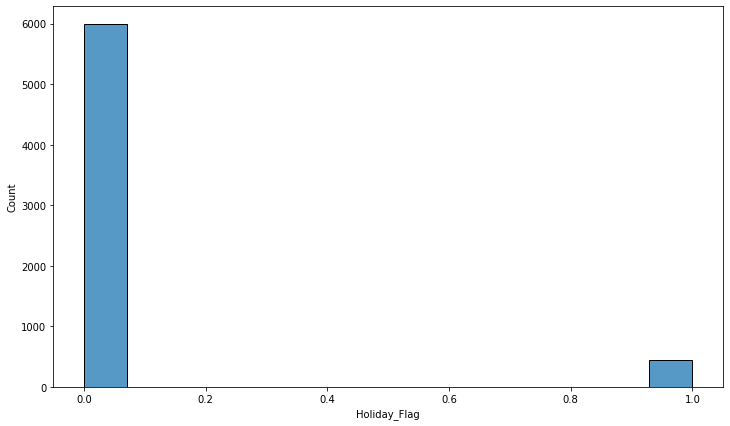

In [12]:
#Visualizing the categorical feature
for x in range(len(cf)):
    plt.subplots(figsize=(12,7))
    sn.histplot(xdata[cf[x]]);
    

In [13]:
#Date conversion 
hdata["Date"]=pd.to_datetime(hdata["Date"])

In [14]:
#Date tranforming to month and year
hdata["month"]=pd.to_datetime(hdata["Date"]).dt.month
hdata["year"]=pd.to_datetime(hdata["Date"]).dt.year

<div style="font-family: Segoe UI; line-height: 2; color: #BF3100; text-align: justify;font-size: 25px">
     <b>Checking newest and oldest store</b>

I am going to create "Store_date" that going to indicate when the store has been opend in the data base. However in order to get this, i am taking the most reletive dates to check newest and oldest dates. 

In [15]:
hdata["Store_date"]=hdata["Date"]
dates=[]
for x in hdata["Store_date"]:
    x=x.date()
    dates.append(x)
    
print("The newest store opened on date in the records: \n",max(dates))  
print("The oldest store opened as on date in the records: \n",min(dates)) 

The newest store opened on date in the records: 
 2012-12-10
The oldest store opened as on date in the records: 
 2010-01-10


In [16]:
data=hdata[(hdata["Weekly_Sales"]>hdata["Weekly_Sales"].min())]

In [17]:
Highest_sale_store=hdata[(hdata["Weekly_Sales"]>1046964)]
Lowest_sale_store=hdata[(hdata["Weekly_Sales"]<1046964)]
hdata["h_sale_store"]=Highest_sale_store["Store"]
hdata["l_sale_store"]=Lowest_sale_store["Store"]

In [18]:
#Christmas dates sale
df=hdata.copy()
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

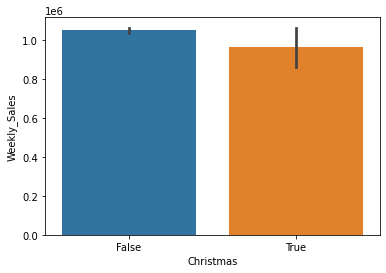

In [19]:
# Christmas holiday vs not-Christmas
sn.barplot(x='Christmas', y='Weekly_Sales', data=df);

<div style="font-family: Segoe UI; line-height: 2; color: #DE3163; text-align: justify;font-size: 25px">
     <b>XGBoosting Hyperparameter Tuning</b>

In [20]:
#Preparing the training and test data
X=xdata[features]
y=xdata.Weekly_Sales.astype(int)

In [21]:
#spliting the data
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3,shuffle = True)

<div style="font-family: Segoe UI; line-height: 2; color: #DE3163; text-align: justify;font-size: 25px">
     <b>XGBoosting and GridSearchCV</b>


In [22]:
#Initializing xgb hyperparameter
params={'learning_rate':[0.01, 0.1],
        'max_depth':[2,5],
        'min_child_weight':[1,3,5],
        'subsample':[.5, .7],
        'n_estimators':[100,150]}

In [23]:
#Creating xgboost regressor object
xgmodel=XGBRegressor()
gsearch=GridSearchCV(estimator=xgmodel,
                     param_grid=params,
                     cv=2,verbose=1,
                     n_jobs=-1,
                    )

In [24]:
#Train the model
gsearch.fit(X_train, y_train)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                  

<div style="font-family: Segoe UI; line-height: 2; color: #FF00FF; text-align: justify;font-size: 25px">
    <b>Model performance evaluation</b>


In [25]:
#Checking the best model score
gsearch.best_score_

0.9408765203868262

In [26]:
#Displaying the best params
gsearch.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 5,
 'n_estimators': 150,
 'subsample': 0.7}

In [27]:
#Checking the features names
gsearch.feature_names_in_

array(['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment'], dtype='<U12')

In [28]:
#predicting the model 
y_pred=gsearch.predict(X_test)
y_pred[:4]

array([ 713307.1, 1839203.2,  600084.1,  546609.8], dtype=float32)

In [29]:
print("Model performance score \n")
print("MSE score \n",mean_squared_error(y_test,y_pred))
print("r2 score \n", r2_score(y_test,y_pred))
print("Explained variance score \n",explained_variance_score(y_test,y_pred))
print("Mean_absolute_error \n",mean_absolute_error(y_test,y_pred))


Model performance score 

MSE score 
 15637813056.261114
r2 score 
 0.9494786471704153
Explained variance score 
 0.9495465733837046
Mean_absolute_error 
 74866.64216241585


<div style="font-family: Segoe UI; line-height: 2; color: #DE3163; text-align: justify;font-size: 25px">
    <b>Feature importances</b>


In [30]:
importances=gsearch.best_estimator_.feature_importances_
f_imp=pd.DataFrame(importances,features )
f_imp

,0
Store,0.566759
Holiday_Flag,0.028247
Temperature,0.020599
Fuel_Price,0.027404
CPI,0.163178
Unemployment,0.193813


<div style="font-family: Segoe UI; line-height: 2; color: #FF00FF; text-align: justify;font-size: 25px">
     <b>RandomizedSearchCV</b>


In [31]:
#hyperparameter initialization 
rparams= {'learning_rate':  uniform(0, 1),
              'n_estimators':   range(50,300),
              'max_depth':      range(3,10)
              }

In [32]:
#initiating randomize object
rsearch=RandomizedSearchCV(estimator=xgmodel, 
                           param_distributions=rparams,
                           cv=2, verbose=1, n_jobs=-1 )

In [33]:
#Train the model
rsearch.fit(X_train,y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                                          min_child_weight=None, missing=nan,
                            

<div style="font-family: Segoe UI; line-height: 2; color: #DE3163; text-align: justify;font-size: 25px">
     <b>Evaluating Model performances</b>


In [34]:
print("RandomizedSearch result \n")
print("Best score \n",rsearch.best_score_)
print("Best params \n", rsearch.best_params_)


RandomizedSearch result 

Best score 
 0.9426705060320565
Best params 
 {'learning_rate': 0.4510146961801724, 'max_depth': 4, 'n_estimators': 259}


In [35]:
#Making the prediction from best model
y_pred=rsearch.predict(X_test)
y_pred[:4]

array([ 684455.44, 1773513.5 ,  573825.9 ,  540831.3 ], dtype=float32)

In [36]:
print("MSE error: \n",mean_squared_error(y_test,y_pred))
print("Mean absolute error: \n",mean_absolute_error(y_test,y_pred))
print("Explained _variance: \n", explained_variance_score(y_test,y_pred))
print("r2 score: \n", r2_score(y_test,y_pred))

MSE error: 
 12424808477.352978
Mean absolute error: 
 68005.93562273434
Explained _variance: 
 0.9598619135546511
r2 score: 
 0.9598589565774968


### <div style="text-align: left; background-color:#CFD9F1 ; font-family: Trebuchet MS; color: #0A3399; padding: 15px; line-height:1;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px">BayesSearchCV</div>

In [37]:
#parameter tuning 
bparams={'max_depth':Integer(2,7),
         'learning_rate':Real(0.01, 0.1,prior='log-uniform'),
          'alpha':Real(1e-5,100,prior='log-uniform'),
          'gamma':Real(1e-9, 0.5,prior='log-uniform'),
         'n_estimators':Integer(50,100)}

In [38]:
#object initilization 
bsearch=BayesSearchCV(estimator=xgmodel,
                      search_spaces=bparams,
                       cv=2,
                       verbose=1
                      )

In [39]:
#training the model
bsearch.fit(X_train,y_train);

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fi

/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 2 folds for each of 1 candidates, totalling 2 fits


<div style="font-family: Segoe UI; line-height: 2; color: #DE3163; text-align: justify;font-size: 25px">
     <b>Evaluating Model performance</b>


In [40]:
#Checking the model score
print("BayesSearch result \n")
print("Best score \n",bsearch.best_score_)
print("Best params \n", bsearch.best_params_)


BayesSearch result 

Best score 
 0.9370038343845913
Best params 
 OrderedDict([('alpha', 0.07781903886232422), ('gamma', 0.49999999999999994), ('learning_rate', 0.0934977999451974), ('max_depth', 7), ('n_estimators', 100)])


In [41]:
#predicting the model
bpred=bsearch.predict(X_test)
bpred

array([ 699925.9 , 1795687.5 ,  591069.44, ..., 1854745.2 ,  949181.8 ,
        556587.44], dtype=float32)

In [42]:
#model performance score
print("BayesSearch error score \n")
print("MSE error :", mean_squared_error(bpred,y_test))
print("\n mean absolute error:", mean_absolute_error(bpred, y_test))
print(" \n R2 score ", r2_score(bpred,y_test))
print("\n explained variance", explained_variance_score(bpred,y_test))

BayesSearch error score 

MSE error : 15628873094.623102

 mean absolute error: 72559.00945915328
 
 R2 score  0.9438317814201969

 explained variance 0.9438616615287998


<div style="font-family: Segoe UI; line-height: 2; color: #DE3163; text-align: justify;font-size: 25px">
     <b>Identified Bes performance ML Model</b>


* GridSearchCV: 94%
* RandomizedSearchCV: 96%
* BayesSearch: 94%

After evaluating the GridSearchCV, RandomizedSearchCV and BayesSearch performances.
Seen the RandomizedSearchCV gave the best performance 96%

<div style="font-family: Segoe UI; line-height: 2; color: #BA90945; text-align: justify;font-size: 25px">
     <b>Implementing LightGBM</b>

LightGBM is a gradient boosting framework based on decision trees to increases the efficiency of the model and reduces memory usage. 

In [43]:
lgbr=LGBMRegressor()

In [44]:
lgbr.fit(X_train,y_train)

LGBMRegressor()

In [45]:
print("Training Accuracy score:\n",lgbr.score(X_train,y_train))
print("Testing Accuracy score:\n",lgbr.score(X_test, y_test))

Training Accuracy score:
 0.9698385528864865
Testing Accuracy score:
 0.9442768574605327


In [46]:
pred=lgbr.predict(X_test)

In [47]:
print("Explained variance score:\n",explained_variance_score(y_test,pred))
print("MSE error: \n",mean_squared_error(y_test,pred))

Explained variance score:
 0.9442803278679817
MSE error: 
 17247916715.11429


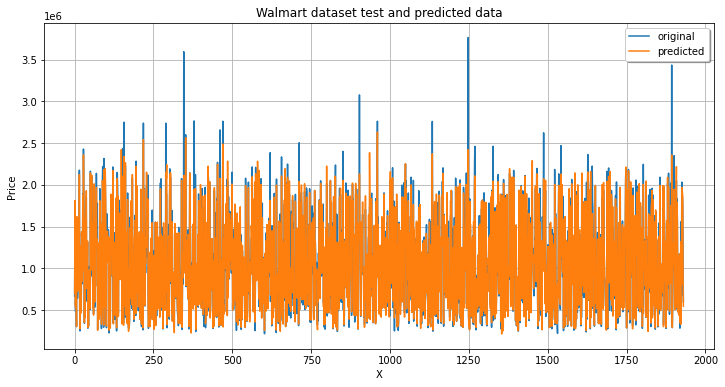

In [48]:
# visualizing in a plot
x_ax = range(len(y_test))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, pred, label="predicted")
plt.title("Walmart dataset test and predicted data")
plt.xlabel('X')
plt.ylabel('Price')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

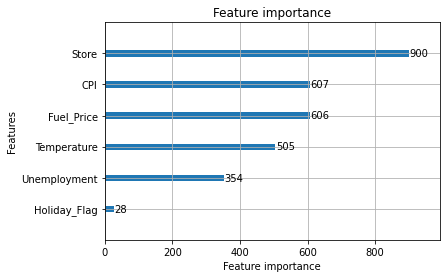

In [49]:
lgb.plot_importance(lgbr);

<div style="font-family: Segoe UI; line-height: 2; color: #AB4169; text-align: justify;font-size: 25px">
     <b>Bayes Search Optimization</b>

In [50]:
#Define the lgbm object
gbm=LGBMRegressor(force_col_wise=True,
                            n_jobs=2,
                            verbose=0,)

In [51]:
#Define the parameters 
params = {
        'boosting'    :   Categorical(['gbdt','dart']),                                                         
        'n_estimators':   Integer(50, 100), # No of boosted trees or iterations to fit (default: 100).

        'num_leaves'  :   Integer(5,45),   # Max tree leaves for base boosters
                                           # Create a node only if no of leaves exceed this limit
                                           #  and also following condition of 'min_child_samples' is met

        'min_child_samples': Integer(1, 50),  # Create a node only if min data-points at this node
                                              #  exceed this limit

        'feature_fraction' : Real(0.1, 0.9),  # Randomly select part of features on each iteration
                                              #  for every boosted tree

        'bagging_fraction' : Real(0.8, 1),   # Randomly select part of data without resampling
                                             #   for each boosted tree

        'bagging_freq'     : Integer(1,10),  # k means perform bagging at every k iteration

        'max_depth'        : Integer(1, 50), # Max tree depth for base learners, -1 means no limit.

        'learning_rate': Real(0.01, 1.0, 'log-uniform'), # Prob of interval 1 to 10 is same as 10 to 100
                                                         # Equal prob of selection from 0.01 to 0.1, 0.1
                                                         # to 1
                                                         # In a loguniform distributon, log-transformed
                                                         # random variable is uniformly distributed

        'reg_lambda': Real(1e-9, 1000, 'log-uniform'),  # L2 regularization term on weights.
        'reg_alpha':  Real(1e-9, 1.0, 'log-uniform'),   #  L1 regularization

        'scale_pos_weight': Real(1, 10),       # default: 1
                                               # used only in binary application
                                               # How much more importance should be given to binary
                                               # weight of labels with positive class


        'max_bin': Integer(100, 1000),        

        'min_child_weight':  Real(1, 10),     # Deals with overfitting

        'subsample_for_bin': Integer(100000, 500000)  #  Number of samples for constructing bins(default: 200000)
                                               # setting this to larger value will give better training
                                               #  result, but will increase data loading time
           }

In [52]:
bayes_tune = BayesSearchCV(
                              estimator = gbm,    # rf, lgb, xgb, nn , pipeline etc--Black box
                              search_spaces = params,  # Specify params as required by the estimator
                              #scoring = 'roc_auc',  # Input to Bayes function
                                                    # modeler should return this
                                                    # peformence metric
                              #cv = cvStrategy,      # Optional. Determines the cross-validation splitting strategy.
                                                    #           Can be cross-validation generator or an iterable,
                                                    #           Possible inputs for cv are: - None, to use the default 3-fold cv,
                                                    #           - integer, to specify the number of folds in a (Stratified)KFold,
                                                    #           - An object to be used as a cross-validation generator.
                              n_jobs = 2,           # Start two parallel threads for processing
                              n_iter = 50,        # How many times to look for parameter sets
                              verbose = 1,
                              refit = True,       #  Refit the best estimator with the entire dataset
                              random_state = 42
                               )

In [53]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [54]:
bayes_tune=BayesSearchCV(estimator = gbm,    # rf, lgb, xgb, nn , pipeline etc--Black box
                         search_spaces = params,  # Specify params as required by the estimator
                              cv = kfold,      
                              n_jobs = 2,           # Start two parallel threads for processing
                              n_iter = 30,        # How many times to look for parameter sets
                              verbose = 1,
                              refit = True,       #  Refit the best estimator with the entire dataset
                              random_state = 42
                      )

In [55]:
import os, time
start = time.time()
bayes_tune.fit(X_train,y_train)
end = time.time()
(end - start)/60

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] bagging_fraction is set=0.8820207917706628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8820207917706628
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.352639674789639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.352639674789639
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.8820207917706628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8820207917706628
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.352639

1.5680081327756246

In [56]:
#Best parameter
bayes_tune.best_params_

OrderedDict([('bagging_fraction', 0.8393965378796446),
             ('bagging_freq', 8),
             ('boosting', 'gbdt'),
             ('feature_fraction', 0.9),
             ('learning_rate', 0.15900974575753943),
             ('max_bin', 454),
             ('max_depth', 20),
             ('min_child_samples', 16),
             ('min_child_weight', 7.944539486290273),
             ('n_estimators', 86),
             ('num_leaves', 45),
             ('reg_alpha', 5.63288136443836e-09),
             ('reg_lambda', 1.3644418228701081e-05),
             ('scale_pos_weight', 1.2501426740490957),
             ('subsample_for_bin', 100000)])

In [57]:
#Best Score
bayes_tune.best_score_

0.9438097872218993

In [58]:
#predicting the model and MSE
pred = bayes_tune.predict(X_test)
mean_squared_error(y_test,pred)

15232715450.478363

In [59]:
bst_bayes = bayes_tune.best_estimator_
pred = bst_bayes.predict(X_test)
bst_bayes.feature_importances_


array([744,  59, 809, 813, 789, 570], dtype=int32)

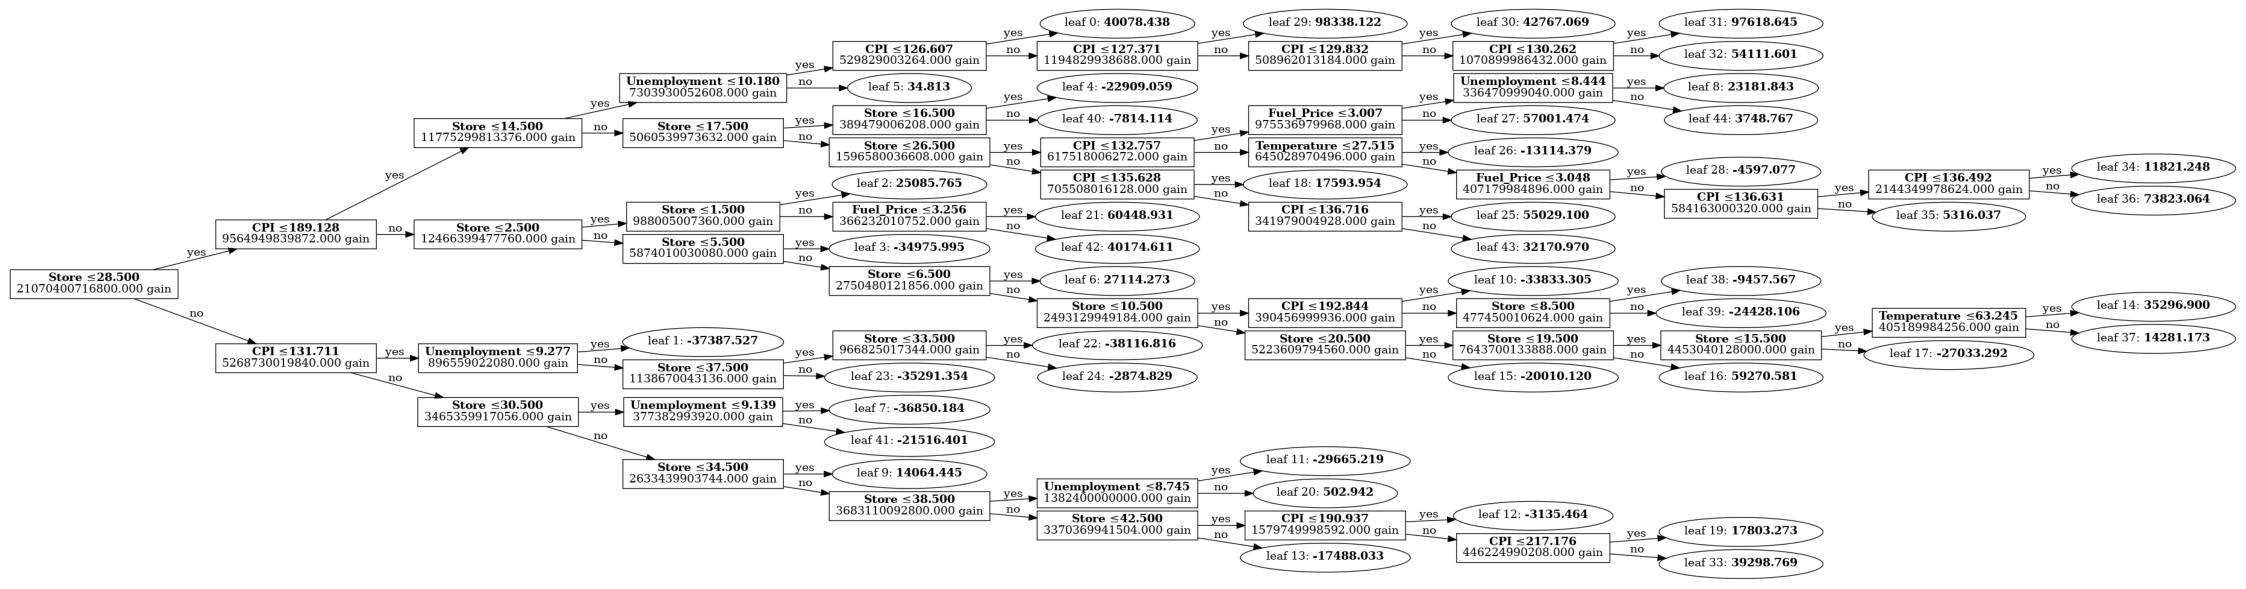

In [60]:
#plotting the Tree
ax= lgb.plot_tree(
                  bst_bayes,
                  tree_index=7,
                  figsize=(40, 20),
                  show_info=['split_gain']
                  )

plt.show()